# Scalable GP Classification in 1D (w/ SVGP)

This example shows how to use grid interpolation based variational classification with an `AbstractVariationalGP` using a `VariationalStrategy` module while learning the inducing point locations. 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(0, 1, 260)
train_y = torch.cos(train_x * (2 * math.pi))

In [3]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
class SVGPRegressionModel(AbstractVariationalGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(-1))
        variational_strategy = VariationalStrategy(self,
                                                   inducing_points,
                                                   variational_distribution,
                                                   learn_inducing_locations=True)
        super(SVGPRegressionModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                log_lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(0.001, 1., sigma=0.1, log_transform=True)
            )
        )
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = SVGPRegressionModel(inducing_points=train_x[:25])
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [4]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.size(0), combine_terms=False)

def train():
    num_iter = 200
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        # Calc loss and backprop gradients
        log_lik, kl_div, log_prior = mll(output, train_y)
        loss = -(log_lik - kl_div + log_prior)
        loss.backward()
        print('Iter %d - Loss: %.3f [%.3f, %.3f, %.3f]' % (i + 1, loss.item(), log_lik.item(), kl_div.item(), log_prior.item()))
        optimizer.step()
        
# Get clock time
with gpytorch.beta_features.diagonal_correction():
    %time train()

/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:74: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


Iter 1 - Loss: 29.468 [-5.286, 24.181, -0.001]
Iter 2 - Loss: 23.192 [-3.997, 19.195, -0.001]
Iter 3 - Loss: 18.659 [-4.088, 14.569, -0.001]
Iter 4 - Loss: 12.908 [-1.447, 11.460, -0.001]
Iter 5 - Loss: 10.229 [-1.383, 8.844, -0.002]
Iter 6 - Loss: 8.041 [-1.399, 6.638, -0.004]
Iter 7 - Loss: 6.311 [-1.405, 4.900, -0.006]
Iter 8 - Loss: 5.023 [-1.407, 3.608, -0.008]
Iter 9 - Loss: 4.121 [-1.410, 2.701, -0.010]
Iter 10 - Loss: 3.509 [-1.400, 2.097, -0.012]
Iter 11 - Loss: 3.160 [-1.393, 1.752, -0.014]
Iter 12 - Loss: 2.955 [-1.378, 1.560, -0.016]
Iter 13 - Loss: 2.820 [-1.380, 1.422, -0.017]
Iter 14 - Loss: 2.761 [-1.380, 1.362, -0.019]
Iter 15 - Loss: 2.734 [-1.381, 1.334, -0.019]
Iter 16 - Loss: 2.694 [-1.381, 1.293, -0.020]
Iter 17 - Loss: 2.679 [-1.381, 1.278, -0.020]
Iter 18 - Loss: 2.668 [-1.381, 1.268, -0.020]
Iter 19 - Loss: 2.654 [-1.380, 1.255, -0.019]
Iter 20 - Loss: 2.652 [-1.379, 1.255, -0.019]
Iter 21 - Loss: 2.657 [-1.377, 1.262, -0.018]
Iter 22 - Loss: 2.662 [-1.373, 1.2

Iter 182 - Loss: -1.030 [1.312, 0.282, -0.001]
Iter 183 - Loss: -0.902 [1.160, 0.257, -0.001]
Iter 184 - Loss: -1.067 [1.310, 0.242, -0.001]
Iter 185 - Loss: -1.109 [1.335, 0.225, -0.001]
Iter 186 - Loss: -1.116 [1.360, 0.243, -0.001]
Iter 187 - Loss: -0.871 [1.162, 0.290, -0.001]
Iter 188 - Loss: -1.147 [1.389, 0.242, -0.001]
Iter 189 - Loss: -1.124 [1.334, 0.209, -0.001]
Iter 190 - Loss: -1.220 [1.454, 0.234, -0.001]
Iter 191 - Loss: -1.077 [1.315, 0.238, -0.001]
Iter 192 - Loss: -1.324 [1.553, 0.228, -0.001]
Iter 193 - Loss: -1.118 [1.348, 0.229, -0.001]
Iter 194 - Loss: -1.284 [1.538, 0.253, -0.001]
Iter 195 - Loss: -1.232 [1.476, 0.243, -0.001]
Iter 196 - Loss: -1.407 [1.638, 0.230, -0.001]
Iter 197 - Loss: -1.325 [1.515, 0.188, -0.001]
Iter 198 - Loss: -1.405 [1.638, 0.232, -0.001]
Iter 199 - Loss: -1.364 [1.587, 0.222, -0.001]
Iter 200 - Loss: -1.421 [1.648, 0.227, -0.001]
CPU times: user 19.8 s, sys: 18.3 s, total: 38.1 s
Wall time: 5.56 s


/home/jrg365/gpytorch/gpytorch/utils/cholesky.py:14: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  potrf_list = [sub_mat.potrf() for sub_mat in mat.view(-1, *mat.shape[-2:])]
/home/jrg365/gpytorch/gpytorch/lazy/added_diag_lazy_tensor.py:74: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
  ld_one = lr_flipped.potrf().diag().log().sum() * 2


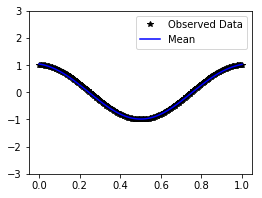

In [5]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad():
    test_x = torch.linspace(0, 1, 101)
    predictions = likelihood(model(test_x)).mean

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
pred_labels = predictions
ax.plot(test_x.data.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [8]:
with gpytorch.beta_features.fast_pred_var():
    print(model(test_x))

MultivariateNormal(loc: torch.Size([101]))
